In [ ]:
# Import necessary libraries
import pandas as pd
from datetime import datetime


## NYU Furman Center Core Data: Subsidized Housing Database 

Subsidized Housing Database download package contains two data files and two corresponding data dictionary files:

The FC_SHD_subsidy_analysis_yyyy-mm-dd.csv file is provided for detailed analysis of subsidies and properties. Each entry in this data file represents the combination of a subsidy record and a property. If multiple subsidies are available for one property (identified by Borough-Block-Lot aka BBL), there will be multiple entries associated with the single BBL. Also, if a single subsidy contract applies to multiple properties, then there will be multiple entries associated with the single subsidy. Along with the subsidy information such as corresponding agency, subsidy type, as well as the start and end date, the subsidy analysis file provides the information of the property including address, the number of residential units, year built and etc. The file also provides latitude and longitude points of the BBLs for potential geospatial analysis. For detailed information, please refer to FC_SHD_subsidy_analysis_data_dictionary_yyyy-mm-dd.xlsx.

The FC_SHD_bbl_analysis_yyyy-mm-dd.csv file will be useful for property-level analysis. Each entry is a unique property (BBL). The data set has compiled all the subsidies associated with the BBL into one entry with the property details, captured in a series of columns for each program. The file also provides latitude and longitude points of the BBLs for potential geospatial analysis. For detailed information, please refer to FC_SHD_bbl_analysis_data_dictionary_yyyy-mm-dd.xlsx.

Moving forward we will use the BBL level data source and collapse binary columns ^prog_* to obtain program level information and end_* columns to obtain and ending date in order to subset only those buildings with current subsidies

In [104]:
# import relevant libraries
import pandas as pd
import numpy as np
import datetime as dt

In [118]:
# read in data

# Read in bbl data for further filtering and munging
df = pd.read_csv("../data/affordablehousing/FC_SHD_bbl_analysis_2022-12-20.csv")

# Read in bbl data and drop all binary columns for later merging
locs = (pd.read_csv("../data/affordablehousing/FC_SHD_bbl_analysis_2022-12-20.csv",
                  dtype = {'tract_10':str,
                          'year_built':str,
                          'sba_id':str})
       ..drop(locs.iloc[:, 22:122], axis = 1))



# filter only those binary program columns and the unique building bbl identifier to use a key
df_filt = df.filter(regex= '^prog_|bbl*')
df_filt.head()

# Melt to get one column of subsidy program names
col_names = list(df_filt.columns[1:30])

df_melt = (df_filt.melt(id_vars = 'bbl', value_vars = col_names, var_name = 'subsidy_program', value_name = 'binary')
          .query('binary == 1'))


# Filter and Melt for end_dates
df_filt = df.filter(regex= '^end_*')
print(len(df_filt.columns))
col_names = list(df_filt.columns[0:29])

dates_melt = df_filt.melt(value_vars = col_names, var_name = 'program_end', value_name = 'end_date')
dates_melt.head() 

# Check to make sure the num of unique bbl is 13152
print(len(np.unique(df_melt['bbl']))) # 13152 (GOOD)


SyntaxError: invalid syntax (2156446105.py, line 11)

## Merge
1. the loc bbl level data with the melted program and end_dates
2. some important metadata regarding target income levels for each subsidy program 


Background:
Properties in the Subsidized Housing Database are tax parcels, identified by a unique  borough-block-lot (BBL) number.

An individual subsidy agreement may apply to more than one property. In some cases, the data we receive only lists a single address for a subsidy even though the agreement covers multiple properties. In order to identify all properties associated with a subsidy, we search New York City property records to identify the related properties. First, we convert the address listed in the subsidy agreement to its BBL using the process described above. We call this property the reference BBL. We then search New York City Department of Finance’s Automated City Register Information System (ACRIS) to identify related properties - properties that are referenced in documents associated with the reference BBL. We then cross-check information in the subsidy agreement with the property information from ACRIS to ensure the related properties are in fact associated (we match based on the number of residential units). We only allow matches to associated BBLs with a building class that falls under the following building classification codes from the Department of Finance: A, B, C, D, R, S, L, I, N, H3, H6, H7, H8, and K4.

<AxesSubplot:>

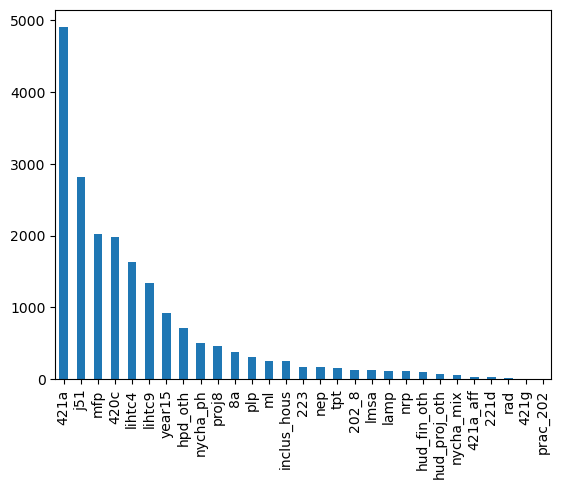

In [122]:
# merge the df_melt and end dates dataframes on index 

final = (pd.merge(df_melt, dates_melt, left_index=True, right_index=True)
         .drop(['binary', 'program_end'], axis = 1)
        )

# clean the subsidy program column up 
final['subsidy_program'] = final['subsidy_program'].str.replace('prog_', '')

# Merge back with the location dataset 'locs' on  unique 'bbl'
locs_final = pd.merge(final, locs, left_on = 'bbl', right_on = 'bbl')

locs_final.head()

# Bar plot
locs_final['subsidy_program'].value_counts().plot(kind='bar')

## Subsetting 
1. Top 10 most common subsidy programs
2. Current subsidies

Background:
Subsidy Start and End Dates: For a given subsidy, the start date indicates when the subsidy was issued or when the property was placed in service. The end date indicates when the requirements associated with the subsidy end or expire. In cases where only the year is known, the start date is set to January 1st and the end date is set to December 31st. 

If a subsidy is permanent or has no foreseeable end date (e.g. Public Housing, Inclusionary Zoning), the end date is listed as blank. Program notes are as follows:

Mitchell-Lama: The end date listed for Mitchell-Lama properties reflects the opt-out date. The Subsidized Housing Database includes Mitchell-Lama properties that have exceeded their opt-out date but (as best we can determine) have not opted out of the program. 
Low-Income Housing Tax Credit (LIHTC): LIHTC data is from HUD’s LIHTC Database and only includes the subsidy start date. For these properties we estimate the end date of the LIHTC subsidy to be 30 years from the start date. 

Therefore in order to obtain only those currently active subsidies (through Jan 1, 2023) I will subset end_dates that occur after Dec 31, 2022 or end_dates that are listed as null. 

In [123]:

# select only those end_dates after 2022-12-31 OR NULL values 
locs_final['end_date'] = pd.to_datetime(locs_final['end_date'], format = '%Y%m%d')

# create a cutoff date variable
stop_date = dt.datetime(2022, 12, 31)

# query for those subsidy end_dates which occur after Dec 31, 2022 to get currently active subsidies
cur_bbl_subsidies = locs_final.query('end_date > @stop_date | end_date.isnull()')

print("No. dropped records: ", len(locs_final)-len(cur_bbl_subsidies))


# Subset the top 10 most frequently occurring subsidies

# eliminate some programs that are 1) not rentals or 2) not well defined (e.g 'other HUD')
cur_bbl_subsidies = cur_bbl_subsidies[~cur_bbl_subsidies.subsidy_program.isin(['221d', '223', '421g', 'hpd_oth', 'hud_fin_oth', 'hud_proj_oth'])]

# Merge in metadata
metadata = pd.read_csv("../data/affordablehousing/subsidy_lookup.csv")

cur_bbl_subsidies = pd.merge(cur_bbl_subsidies, metadata, left_on = 'subsidy_program', right_on = 'subsidy_program')




No. dropped records:  154


## Get Top 10


/var/folders/0p/rh9j3dm51wn8w8hpwmkfvqkw0000gn/T/ipykernel_42428/2499631866.py:2: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  subsidy_id = pd.read_csv('../data/affordablehousing/FC_SHD_subsidy_analysis_2022-12-20.csv')


['421-a Tax Incentive Program', 'J-51 Tax Incentive', '420-c Tax Incentive Program', 'LIHTC 4%', 'LIHTC 9%', 'Federal Public Housing', 'Project-Based Section 8', 'Mitchell-Lama', 'Section 202/8', 'Loan Management Set-Aside']


<AxesSubplot:>

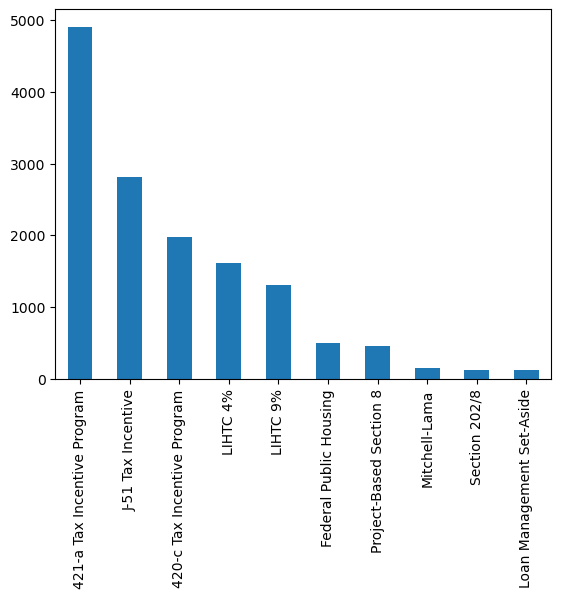

In [129]:
# get top 10 for further analysis
subsidy_id = pd.read_csv('../data/affordablehousing/FC_SHD_subsidy_analysis_2022-12-20.csv')
subsidy_id = subsidy_id[~subsidy_id.sub_subsidy_name.isin(['Section 223(f)', 'Other HUD Financing'])]

top10 = subsidy_id['sub_subsidy_name'].value_counts().index.tolist()[0:10] # last number is not inclusive

print(top10)


# Subset the relevant subsidy program categories
subsidies = cur_bbl_subsidies[cur_bbl_subsidies['subsidy_program_full'].isin(top10)]


# Bar plot
subsidies['subsidy_program_full'].value_counts().plot(kind='bar')



## Exploratory Data Analysis

1. Subsidies by Borough
2. Subsidies by Program Type (sub_subsidy_name)

<AxesSubplot:>

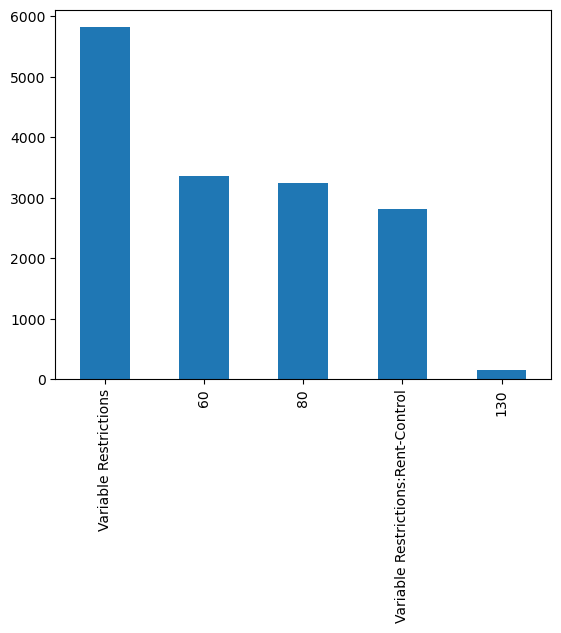

In [134]:
# Number of currently active subsidy-building by Borough
#sub_boro = cur_subsidies.groupby('boro_name').size()
#print(sub_boro)
# Bar plot of subsidies by borough
subsidies['boro_name'].value_counts().plot(kind='bar')




# Number of currently active subsidy-building by income designation
# Bar plot of subsidies by borough
subsidies['boro_name'].value_counts().plot(kind='bar')

# Bar plot of subsidies by income 
subsidies['Max Income Restriction(%AMI)'].value_counts().plot(kind='bar')


# Get building and unit counts  

In [135]:
subsidies.head()

,bbl,subsidy_program,end_date,standard_address,city_id,city_name,boro_id,boro_name,cd_id,cd_name,...,Scale,Timeframe,Occupancy Tenure,Construction Type,Building Type,Max Income Restriction(%AMI),Occupancy Demographic,Income Designation,Project Eligibility,Developers/Owners
0,1002480070,202_8,2033-06-30,80 Rutgers Slip,1,New York City,1,Manhattan,103,MN 03 - Lower East Side/Chinatown,...,"Very Large Scale (>10,000 units)",1978-Present,Rental,Rehabilitation,Multi-family,60,Seniors; Persons with Disabilities,Extremely-low:Very-low,NaN,Non-profit
1,1003360005,202_8,2032-12-19,15 Bialystoker Place,1,New York City,1,Manhattan,103,MN 03 - Lower East Side/Chinatown,...,"Very Large Scale (>10,000 units)",1978-Present,Rental,Rehabilitation,Multi-family,60,Seniors; Persons with Disabilities,Extremely-low:Very-low,NaN,Non-profit
2,1012020001,202_8,2039-12-31,69 West 88 Street,1,New York City,1,Manhattan,107,MN 07 - Upper West Side,...,"Very Large Scale (>10,000 units)",1978-Present,Rental,Rehabilitation,Multi-family,60,Seniors; Persons with Disabilities,Extremely-low:Very-low,NaN,Non-profit
3,1003850053,202_8,2028-06-21,234 East 2 Street,1,New York City,1,Manhattan,103,MN 03 - Lower East Side/Chinatown,...,"Very Large Scale (>10,000 units)",1978-Present,Rental,Rehabilitation,Multi-family,60,Seniors; Persons with Disabilities,Extremely-low:Very-low,NaN,Non-profit
4,1004010029,202_8,2028-06-21,538 East 6 Street,1,New York City,1,Manhattan,103,MN 03 - Lower East Side/Chinatown,...,"Very Large Scale (>10,000 units)",1978-Present,Rental,Rehabilitation,Multi-family,60,Seniors; Persons with Disabilities,Extremely-low:Very-low,NaN,Non-profit


## SCRATCH

In [67]:
# SCRATCH
#print(len(df.columns))

# use df.dot to collapse all binary prog_* columns into one column 
#subsidy = pd.DataFrame(df_filt.dot(df_filt.columns))

#subsidy.index.names = ['IDX']

# Rename to something sensical
#subsidy = subsidy.rename(columns={0: 'subsidy_program'})


# now collapse the dates

#end_date = (df[df.filter(like='end') # Using filter to select certain columns.
#                     .columns
#                     .sort_values(ascending=False)] # Sort them descending.
#                  .bfill(axis=1) # backfill values
#                  .iloc[:,0]) # take the first column, 
                              # This has the first non-nan value.

#subsidy['max_end_date'] = end_date

122


Index(['bbl', 'standard_address', 'city_id', 'city_name', 'boro_id',
       'boro_name', 'cd_id', 'cd_name', 'sba_id', 'sba_name', 'ccd_id',
       'ccd_name', 'tract_10', 'res_units', 'year_built', 'buildings',
       'assessed_value', 'owner_name', 'ser_violation', 'tax_delinquency',
       'latitude', 'longitude'],
      dtype='object')